# what's the neuron yield across probes, experimenters and recording sites?
Anne Urai & Nate Miska, 2020

In [1]:
# GENERAL THINGS FOR COMPUTING AND PLOTTING
import pandas as pd
import numpy as np
import os, sys, time
import scipy as sp

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# ibl specific things
import datajoint as dj
from ibl_pipeline import reference, subject, action, acquisition, data, behavior
ephys = dj.create_virtual_module('ephys', 'ibl_ephys')
figpath = os.path.join(os.path.expanduser('~'), 'Data/Figures_IBL')

Connecting anneurai@datajoint.internationalbrainlab.org:3306


## 1. neuron yield per lab and Npix probe over time
Replicates https://github.com/int-brain-lab/analysis/blob/master/python/probe_performance_over_sessions.py using DJ

In [4]:
probe_insertions = ephys.ProbeInsertion * ephys.DefaultCluster.Metrics * subject.SubjectLab
probe_insertions = probe_insertions.proj('probe_serial_number', 'probe_model_name', 'lab_name', 'metrics',
                                         session_date='DATE(session_start_time)')
clusts = probe_insertions.fetch(format='frame').reset_index()

In [5]:
# put metrics into df columns from the blob
for kix, k in enumerate(['ks2_label']):
    tmp_var = []
    for id, c in clusts.iterrows():
        if k in c['metrics'].keys():
            tmp = c['metrics'][k]
        else:
            tmp = np.nan
        tmp_var.append(tmp)
    clusts[k] = tmp_var
    
clusts

,subject_uuid,session_start_time,probe_idx,cluster_id,probe_model_name,probe_serial_number,metrics,lab_name,session_date,presence_ratio,presence_ratio_std,amplitude_cutoff,amplitude_std,epoch_name,ks2_label,isi_viol,ks2_contamination_pct
0,221b68e7-0014-46ae-b8af-308665d8b478,2020-01-29 16:19:34,0,0,3A,513180850,"{'presence_ratio': 0.9839743589743588, 'presen...",churchlandlab,2020-01-29,0.983974,23.676066,0.500000,3.409446,0,mua,3.897612,100.0
1,221b68e7-0014-46ae-b8af-308665d8b478,2020-01-29 16:19:34,0,1,3A,513180850,"{'presence_ratio': 0.8173076923076923, 'presen...",churchlandlab,2020-01-29,0.817308,11.801279,0.500000,5.797017,0,mua,10.510968,100.0
2,221b68e7-0014-46ae-b8af-308665d8b478,2020-01-29 16:19:34,0,2,3A,513180850,"{'presence_ratio': 0.875, 'presence_ratio_std'...",churchlandlab,2020-01-29,0.875000,12.979735,0.500000,10.152207,0,mua,54.584951,100.0
3,221b68e7-0014-46ae-b8af-308665d8b478,2020-01-29 16:19:34,0,3,3A,513180850,"{'presence_ratio': 1.0, 'presence_ratio_std': ...",churchlandlab,2020-01-29,1.000000,21.002973,0.500000,3.696557,0,mua,1.571842,100.0
4,221b68e7-0014-46ae-b8af-308665d8b478,2020-01-29 16:19:34,0,4,3A,513180850,"{'presence_ratio': 0.9935897435897436, 'presen...",churchlandlab,2020-01-29,0.993590,13.948795,0.500000,2.615109,0,mua,2.314795,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95331,b55c97f2-1024-4b16-9774-2d9049942f98,2020-01-31 14:36:40,1,385,3B2,18194824312,"{'presence_ratio': 0.389344262295082, 'presenc...",mainenlab,2020-01-31,0.389344,1.026457,0.189836,2.591832,0,mua,0.000000,100.0
95332,b55c97f2-1024-4b16-9774-2d9049942f98,2020-01-31 14:36:40,1,386,3B2,18194824312,"{'presence_ratio': 0.6147540983606558, 'presen...",mainenlab,2020-01-31,0.614754,4.861815,0.208040,4.597110,0,good,0.000000,0.0
95333,b55c97f2-1024-4b16-9774-2d9049942f98,2020-01-31 14:36:40,1,387,3B2,18194824312,"{'presence_ratio': 0.5409836065573771, 'presen...",mainenlab,2020-01-31,0.540984,1.131586,0.500000,1.016704,0,mua,0.000000,100.0
95334,b55c97f2-1024-4b16-9774-2d9049942f98,2020-01-31 14:36:40,1,388,3B2,18194824312,"{'presence_ratio': 0.9959016393442623, 'presen...",mainenlab,2020-01-31,0.995902,54.676247,0.165644,1.759487,0,good,0.041780,4.9


In [25]:
clusts['probe_name'] = clusts['lab_name'] + ', ' + clusts['probe_model_name'] + ': ' + clusts['probe_serial_number']

clusts_summ = clusts.groupby(['probe_name', 'session_start_time', 'ks2_label'])['session_date'].count().reset_index()

# use recording session number instead of date
clusts_summ['recording'] = clusts_summ.groupby(['probe_name']).cumcount() + 1
clusts_summ

,probe_name,session_start_time,ks2_label,session_date,recording
0,"angelakilab, 3B2: 18005102352",2020-01-24 14:22:03,good,175,1
1,"angelakilab, 3B2: 18005102352",2020-01-24 14:22:03,mua,500,2
2,"angelakilab, 3B2: 18005102352",2020-02-18 14:25:54,good,31,1
3,"angelakilab, 3B2: 18005102352",2020-02-18 14:25:54,mua,62,2
4,"angelakilab, 3B2: 18005108752",2020-01-20 16:55:52,good,174,1
...,...,...,...,...,...
511,"zadorlab, 3B2: 18194822771",2020-03-21 14:17:23,mua,185,2
512,"zadorlab, 3B2: 18194822771",2020-03-22 12:56:40,good,123,1
513,"zadorlab, 3B2: 18194822771",2020-03-22 12:56:40,mua,244,2
514,"zadorlab, 3B2: 18194822771",2020-03-23 12:58:00,good,295,1


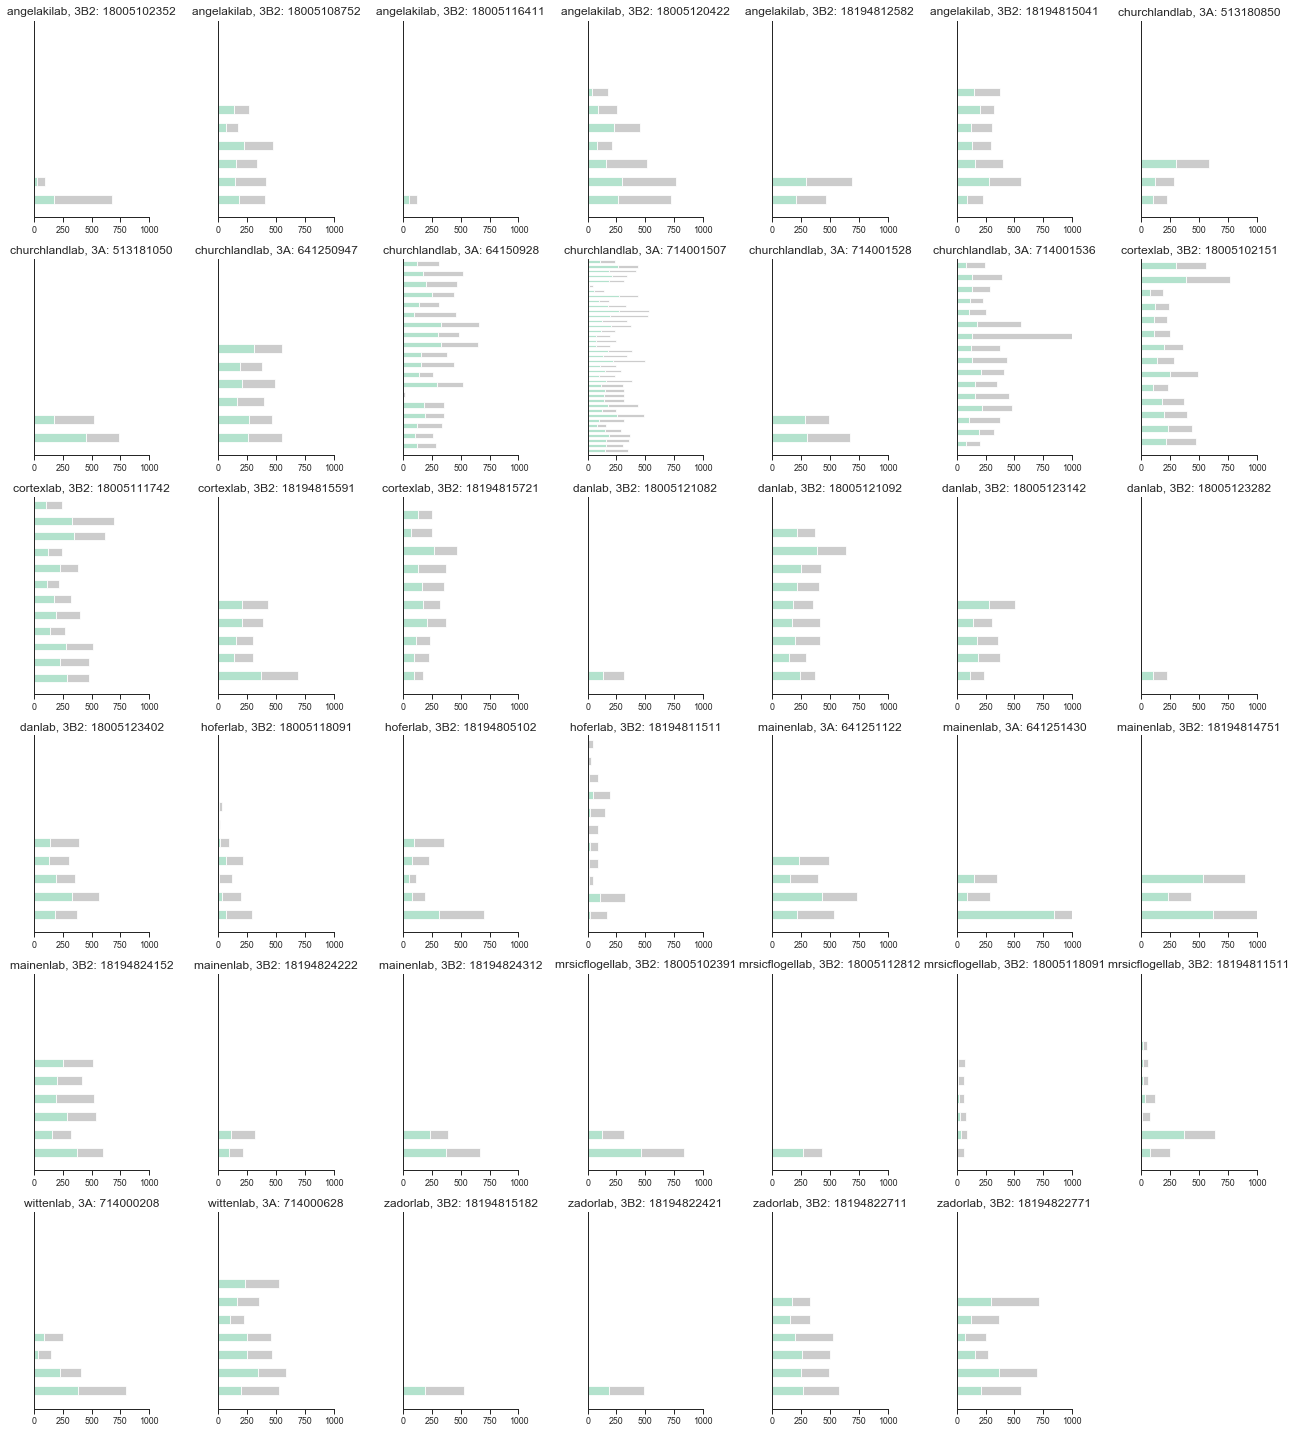

In [36]:
sns.set(style="ticks", context="paper")
g, axes = plt.subplots(6,7,figsize=(18,20))

for probe, ax in zip(clusts_summ.probe_name.unique(), axes.flatten()):
    df = clusts_summ[clusts_summ.probe_name==probe].groupby(['session_start_time','ks2_label']).session_date.sum()
    df.unstack().plot.barh(ax=ax, stacked=True, legend=False, colormap='Pastel2')
    ax.set_title(probe, fontsize=12)
    ax.set_yticks([])
    ax.set_ylabel('')
    ax.set_ylim([-1, np.max([max(ax.get_ylim()), 10])])
    ax.set_xlim([0, 1000])
    
axes.flatten()[-1].set_axis_off()
sns.despine(trim=True)   
plt.tight_layout()
plt.xlabel('Number of KS2 neurons')
plt.ylabel('Recording session')
g.savefig(os.path.join(figpath, 'probe_yield_oversessions.pdf'))

## 2. how does probe yield in the repeated site differ between mice/experimenters?

In [107]:
probes_rs = (ephys.ProbeTrajectory & 'insertion_data_source = "Planned"'
             & 'x BETWEEN -2400 AND -2100' & 'y BETWEEN -2100 AND -1900'
             & 'theta BETWEEN 14 AND 16')

clust = ephys.DefaultCluster * ephys.DefaultCluster.Metrics * probes_rs * subject.SubjectLab()
clust = clust.proj('cluster_amp', 'cluster_depth', 'firing_rate', 'subject_nickname', 'lab_name','metrics',
                   'x', 'y', 'theta', 'phi', 'depth')
clusts = clust.fetch(format='frame').reset_index()
clusts['col_name'] = clusts['lab_name'] + ', ' + clusts['subject_nickname']

# put metrics into df columns from the blob
for kix, k in enumerate(clusts['metrics'][0].keys()):
    tmp_var = []
    for id, c in clusts.iterrows():
        if k in c['metrics'].keys():
            tmp = c['metrics'][k]
        else:
            tmp = np.nan
        tmp_var.append(tmp)
    clusts[k] = tmp_var

print(clusts.describe())

# cluster_amp: now in KS2 units, convert to uV
# see https://int-brain-lab.slack.com/archives/CK9QY8C82/p1584623970061900
clusts['cluster_amp'] = clusts['cluster_amp'] * 1/2.3 * 10**6

ks2_label,probe_name,session_start_time,good,mua,all,recording
0,"angelakilab, 3B2: 18005102352",2020-01-24 14:22:03,175,500,675,1
1,"angelakilab, 3B2: 18005102352",2020-02-18 14:25:54,31,62,93,2
2,"angelakilab, 3B2: 18005108752",2020-01-20 16:55:52,174,231,405,1
3,"angelakilab, 3B2: 18005108752",2020-01-22 15:39:55,143,268,411,2
4,"angelakilab, 3B2: 18005108752",2020-01-23 14:56:31,151,184,335,3
5,"angelakilab, 3B2: 18005108752",2020-02-11 11:02:36,222,253,475,4
6,"angelakilab, 3B2: 18005108752",2020-02-13 10:58:33,67,106,173,5
7,"angelakilab, 3B2: 18005108752",2020-02-14 11:03:38,138,125,263,6
8,"angelakilab, 3B2: 18005116411",2019-11-21 17:22:58,56,63,119,1
9,"angelakilab, 3B2: 18005120422",2019-11-26 12:00:15,261,461,722,1


In [ ]:
## where are those insertions?
print('plotting')
g = sns.FacetGrid(data=clusts, col='col_name', col_wrap=4, hue='ks2_label',
                  palette=dict(good="seagreen", mua="orange"))
g.map(sns.scatterplot, "firing_rate", "cluster_depth", alpha=0.5).add_legend()
g.set_titles('{col_name}')
g.set_xlabels('Firing rate (spks/s)')
g.set_ylabels('Depth')
plt.tight_layout()
sns.despine(trim=True)
g.savefig(os.path.join(figpath, 'neurons_rsi_firingrate.pdf'))
